ME1/1, Bend angle variable; number of bits optimization study.

In [1]:
nbits_MK = 41
model_name_MK = 'model_MK_'+str(nbits_MK)+'bits'
weights_name_MK = model_name_MK+'_weights'
print('model_name: ',model_name_MK)
print('weight_name: ',weights_name_MK)

('model_name: ', 'model_MK_41bits')
('weight_name: ', 'model_MK_41bits_weights')


In [2]:
# to import codes in different directory
import sys
sys.path.append('../test8/')

from nn_globals import *
from nn_encode import nlayers, nvariables
# MK: nn_data_MK_andrew -> muon_data_split, pileup_data_split-> muon_data, pileup_data -> Encoder_MK(in nn_encode)
from nn_data_MK_andrew import (muon_data_split, pileup_data_split, mix_training_inputs)
from nn_models import (create_model, create_model_bn, create_model_pruned, 
                       create_model_sequential, create_model_sequential_bn,
                       lr_decay, modelbestcheck, modelbestcheck_weights)
from nn_training import train_model
from nn_pruning import prune_model
%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_2_0
[INFO    ] Using numpy 1.14.1


('learning_rate = ', 0.0063)
('reg_pt_scale = ', 100.0)
('discr_loss_weight = ', 20.0)


[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 1.5.2


In [3]:
# Import muon data
# 'x' is the input variables with shape (n, 87), 'y' is the q/pT with shape (n, 1)
adjust_scale=3
x_train, x_test0, y_train, y_test0, y_eta_train, y_eta_test0, w_train, w_test0, x_mask_train, x_mask_test0 = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.31,nbits=nbits_MK, \
                    get_eta=True)

# Add discrimator output node
if add_noise:
    labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
    y_train = [y_train, labels.astype(np.float32)]
    labels = np.where(np.abs(1.0/y_test0) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
    y_test0 = [y_test0, labels.astype(np.float32)]

[INFO    ] Loading muon data from /uscms_data/d3/mkim/MKWorkingArea/CMSSW_10_2_0/src/JL/Melrose/P2_CMSSW_10_1_5/src/L1TMuonSimulations/Analyzers/test7/histos_tba.20.npz ...
../test8/MK_proc.py:70: RuntimeWarning: invalid value encountered in greater_equal
  numsSign[numsSign >= 0] = 1
../test8/MK_proc.py:71: RuntimeWarning: invalid value encountered in less
  numsSign[numsSign < 0] = -1
[INFO    ] Loaded the variables with shape (3272341, 87)
[INFO    ] Loaded the parameters with shape (3272341, 3)


3272341
('nbits: ', 41)
('nanStd: ', 14.538398582759314)
('me1bendSF: ', -0.06878336663474562)


[INFO    ] Loaded the encoded variables with shape (3272341, 39)
[INFO    ] Loaded the encoded parameters with shape (3272341,)
[INFO    ] Loaded # of training and testing events: (2257915, 1014426)


In [4]:
# selecting examples limited in 1.65 < |eta| < 2.4
eta_region_ind = np.where((1.65<np.abs(y_eta_test0)) & (np.abs(y_eta_test0)<2.4))[0]

x_test = x_test0[eta_region_ind]
y_test = []
for i in [0,1]:
    y_test.append(y_test0[i][eta_region_ind])
y_eta_test = y_eta_test0[eta_region_ind]
w_test = w_test0[eta_region_ind]
x_mask_test = x_mask_test0[eta_region_ind]

assert(len(eta_region_ind) == len(y_test[0]))
assert(len(x_test) == len(y_test[0]))

In [5]:
np.min(np.abs(y_eta_test))

1.6500025

In [6]:
# Import pileup data
# 'x' is the input variables with shape (n, 87), 'aux' is pileup info with shape (n, 4)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_job=131,nbits=nbits_MK)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from /uscms_data/d3/mkim/MKWorkingArea/CMSSW_10_2_0/src/JL/Melrose/P2_CMSSW_10_1_5/src/L1TMuonSimulations/Analyzers/test7/histos_tbd.20.npz ...


clip performed
('max: ', 28.0)
('std: ', 22.628826841802578)
('min: ', -28.0)
[ 0  3  8 12 16 20 24 28]


[INFO    ] Loaded the variables with shape (816244, 87)
[INFO    ] Loaded the auxiliary PU info with shape (816244, 4)


[-31.38159   31.38159  -57.225254 -41.       -35.              nan
        nan        nan        nan  53.533302]
[-28.  28. -28. -28. -28.  29.  29.  29.  29.  28.]
('nbits: ', 41)
('nanStd: ', 22.628826841802578)
('me1bendSF: ', -0.0441914203944804)


[INFO    ] Loaded the encoded variables with shape (816244, 39)
[INFO    ] Loaded the encoded auxiliary PU info with shape (816244, 4)
[INFO    ] Loaded # of training and testing events: (652320, 163924)


### Training

In [7]:
# Hello, what do you want to train today?

training_seq    = False
training_func   = False
training_bn     = True
training_pruned = False

In [8]:
# Training with Batch Normalization
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator

if training_bn:
    assert(keras.backend.backend() == 'tensorflow')
    
    if add_noise:
        x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut, tile=5)
    else:
        raise Exception('add_noise must be set to True')
    
    model = create_model_bn(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                            nodes1=50, nodes2=30, nodes3=20)
    
    logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
    
    normal_epochs = 300
    normal_batch_size = 256*4*2
    
    history = train_model(model, x_train_new, y_train_new,
                          model_name=model_name_MK, epochs=normal_epochs, batch_size=normal_batch_size,
                          callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
    
    metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
               history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
    logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

[INFO    ] Mixed muon data with pileup data. x_train_new has shape (4515830, 39), y_train_new has shape (4515830,),(4515830,)
[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0
[INFO    ] Begin training ...


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           1950        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50)           200         dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 50)           0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_2 (D

[INFO    ] Done training. Time elapsed: 5:33:19.849684 sec
[INFO    ] Epoch 300/300 - loss: 0.171614658148 - regr_loss: 2.73549745296 - discr_loss: 0.0348397827305 - val_loss: 0.170140268075 - val_regr_loss: 2.70907587273 - val_discr_loss: 0.0346864711323


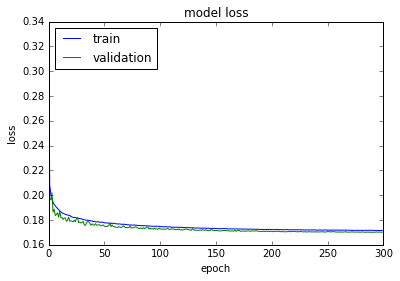

[INFO    ] # of entries: 167319, mean: -0.000770696380641, std: 0.0404345989227
[INFO    ] gaus fit (a, mu, sig): [ 1.45475006e+04 -3.63394545e-04  2.43684416e-02]


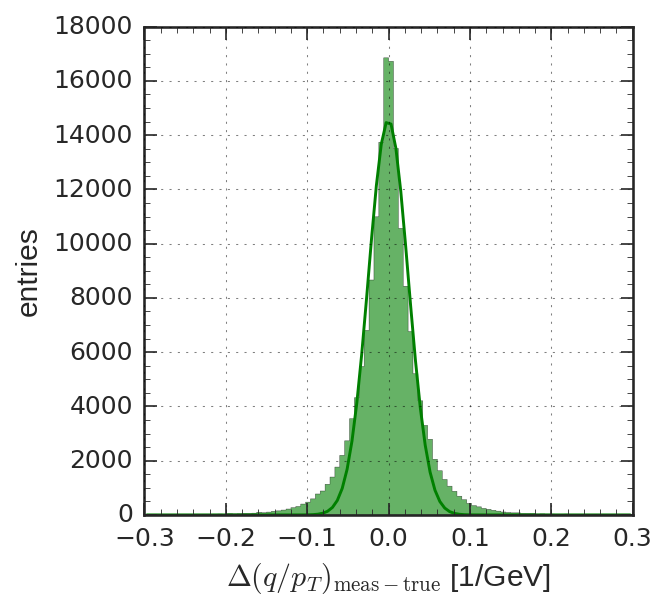

[INFO    ] # of entries: 167319, mean: 0.191829159856, std: 0.244271337986
[INFO    ] gaus fit (a, mu, sig): [ 1.81928137e+04 -6.85034914e-03  1.31257777e-01]


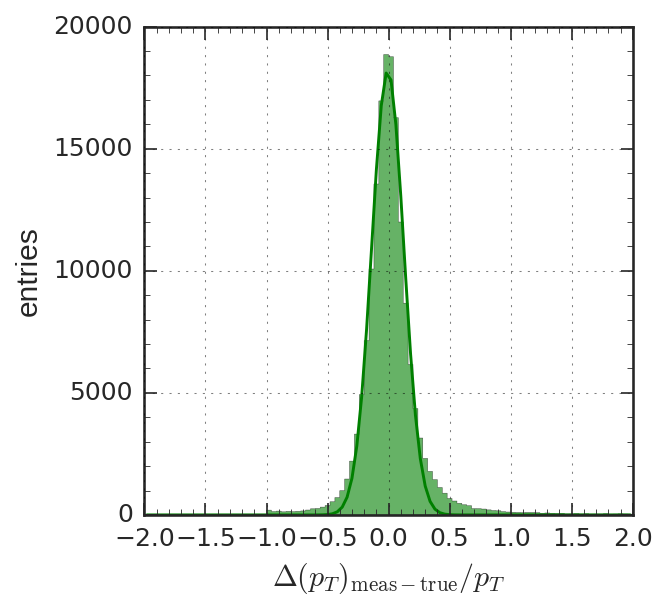

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-gnimlf2/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


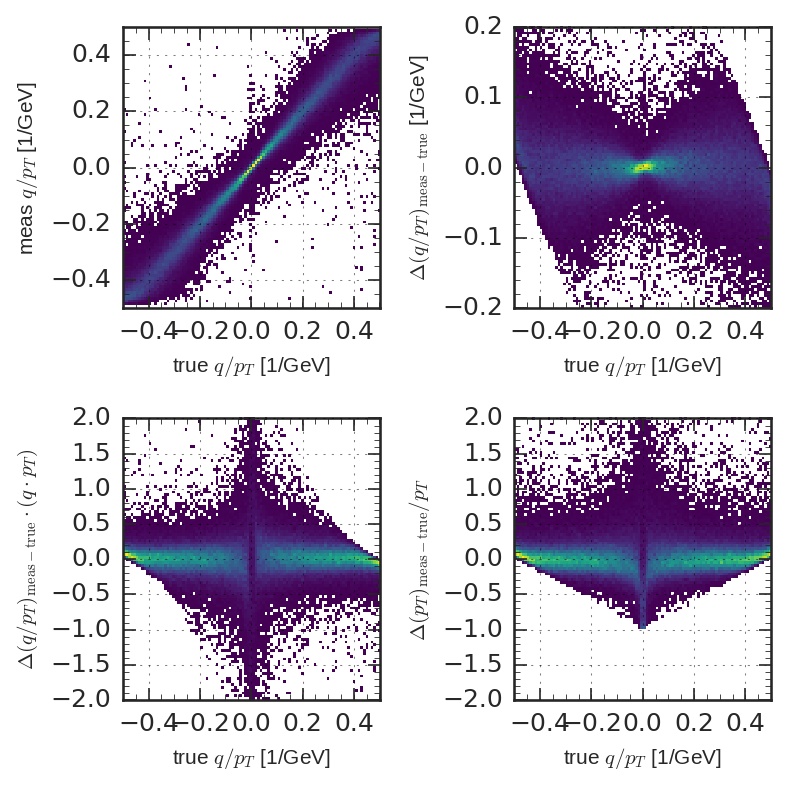

[INFO    ] gaus fit (a, mu, sig): [ 1.31225882e+02 -6.79300134e-02  1.94303206e-01]


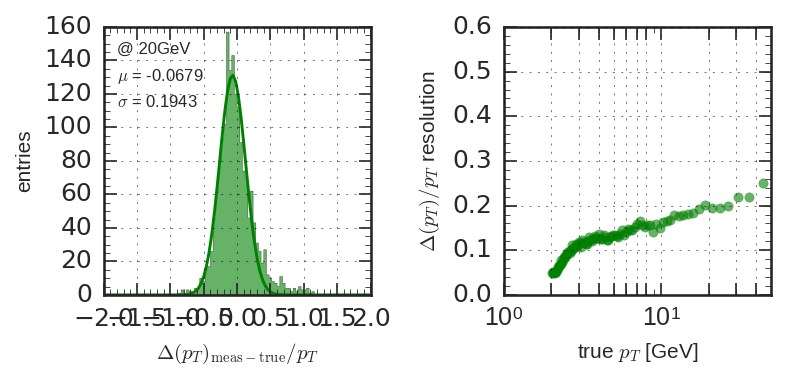

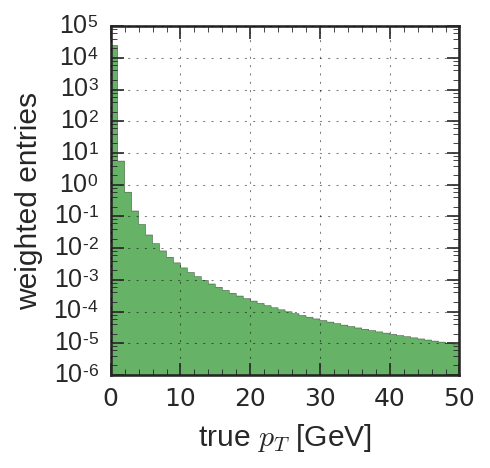

[INFO    ] 20 GeV threshold 14.8241796494 rate 169.917297363
[INFO    ] 22 GeV threshold 15.6262569427 rate 152.843658447


In [9]:
# Validation
#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=4096)

if training_seq or training_func or training_bn or training_pruned:
    # Loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Regression Results

# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name=model_name_MK, weights_name=weights_name_MK)
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//4

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
    y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_meas, list):
    y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.2)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(1,50)
axs[1].set_ylim(0,0.6+eps)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
axs[1].set_xscale('log')
axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

### Classification Results

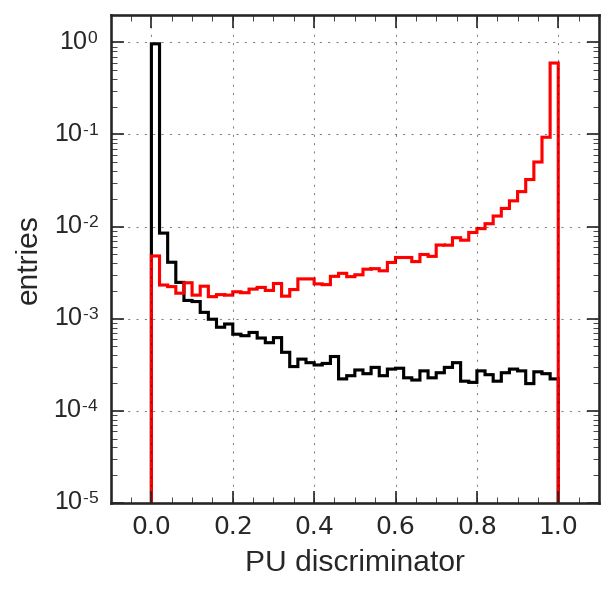

[INFO    ] auc: 0.962173384709
[INFO    ] thr: [0.8932, 0.8596, 0.8075, 0.7312, 0.7042, 0.6625, 0.6125, 0.5299, 0.0745]
[INFO    ] tpr: [0.9002, 0.9257, 0.9501, 0.9700, 0.9751, 0.9804, 0.9855, 0.9902, 0.9990]
[INFO    ] fpr: [0.1225, 0.1568, 0.1972, 0.2456, 0.2678, 0.2907, 0.3069, 0.3331, 0.4724]


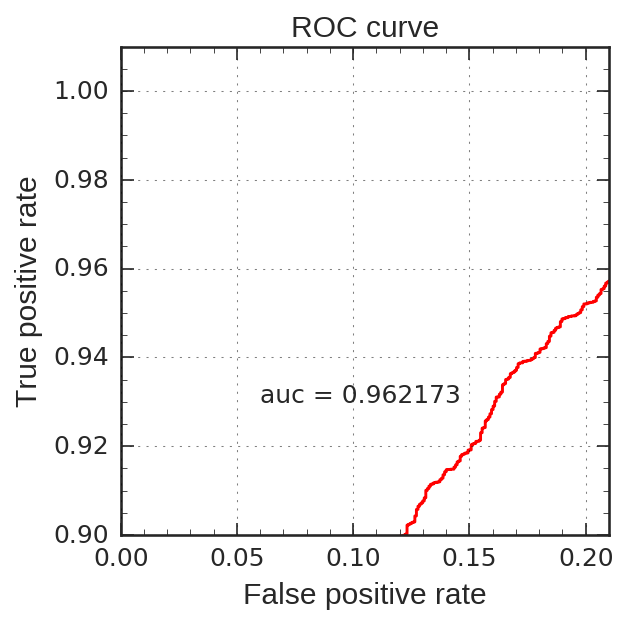

[INFO    ] auc: 0.986431184871
[INFO    ] thr: [0.9745, 0.9644, 0.9343, 0.8908, 0.8704, 0.8278, 0.7866, 0.6808, 0.0810]
[INFO    ] tpr: [0.9021, 0.9262, 0.9556, 0.9705, 0.9751, 0.9813, 0.9852, 0.9903, 0.9990]
[INFO    ] fpr: [0.0304, 0.0384, 0.0496, 0.0688, 0.0784, 0.0896, 0.1024, 0.1376, 0.3232]


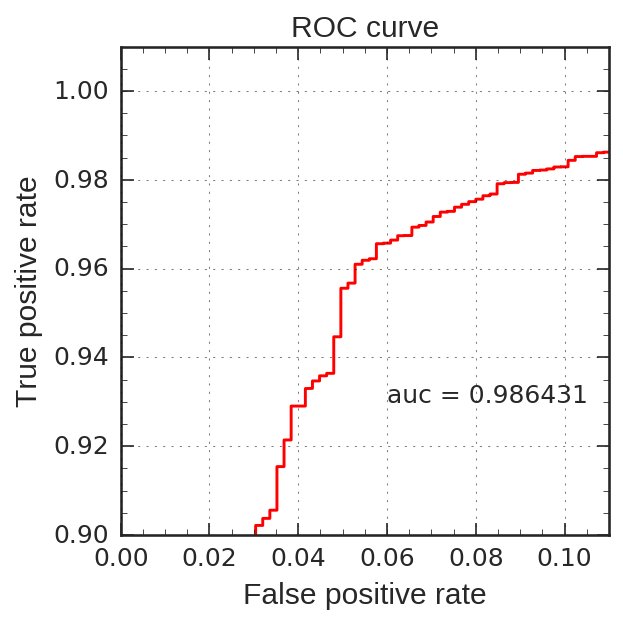

In [10]:
# Prepare y_test_true, y_test_meas (again)
y_test_true = [y_test[0][:nentries_test].copy(), y_test[1][:nentries_test].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=4096)
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

def roc_singlemu(x_mask):
  valid = ~x_mask
  mode = np.int32(0)
  if np.any([valid[0], valid[1]]):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any([valid[2]]):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any([valid[3]]):  # ME3, RE3
    mode |= (1<<1)
  if np.any([valid[4]]):  # ME4, RE4
    mode |= (1<<0)
  return mode in (11,13,14,15)

# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black', lw=1.5)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red', lw=1.5)
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

# Plot ROC
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))
tt = np.concatenate((x_mask_test[:nentries_test][y_test_sel], pu_x_mask_test[pu_y_test_sel]))

tt = np.apply_along_axis(roc_singlemu, 1, tt)  # require SingleMu quality
xx = xx[:, np.newaxis]
xx = xx[tt]
yy = yy[tt]
zz = zz[tt]

zzz = np.abs(1.0/zz) > discr_pt_cut  # meas pT > 8 GeV
xxx = xx[zzz]
yyy = yy[zzz]

fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.06, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,0.21)
plt.ylim(0.9,1.01)
plt.show()

# Plot ROC (for pT > 14 GeV)
zzz = np.abs(1.0/zz) > 14
xxx = xx[zzz]
yyy = yy[zzz]

fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.06, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,0.11)
plt.ylim(0.9,1.01)
plt.show()

### Efficiency & Rates 

0 3 0.000232883918216 3.89396537138 4.1198720932 4.1198720932 [ True]
1 4 0.000910282833502 4.42436284899 4.52562999725 4.52562999725 [ True]
2 3 0.0154709359631 5.40970385582 4.96774625778 4.96774625778 [ True]
3 3 1.44498299051e-05 2.89595154569 2.69381308556 2.69381308556 [ True]
4 4 7.67230885685e-05 3.94286688583 3.20653653145 3.20653653145 [ True]
5 3 3.22334672092e-05 2.06544204286 2.24273324013 2.24273324013 [ True]
6 3 0.820301413536 8.82736848876 9.16010856628 9.16010856628 [False]
7 4 0.183186352253 6.13448637913 6.34637737274 6.34637737274 [ True]
8 3 0.999771416187 12.6086367712 17.2692680359 17.2692680359 [ True]
9 4 0.993508577347 34.1395063245 28.5827999115 28.5827999115 [ True]
10 4 0.000303519249428 3.23169699759 2.78866004944 2.78866004944 [ True]
11 4 7.29434541427e-05 3.93265050598 3.59401297569 3.59401297569 [ True]
12 3 0.998520791531 24.7641472106 27.4727325439 27.4727325439 [ True]
13 2 1.06729512481e-05 2.29566190208 2.27135181427 2.27135181427 [False]
14 3 0.

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:241: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.14.1-gnimlf/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.14.1-gnimlf/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:253: RuntimeWarning: invalid value encountered in true_divide


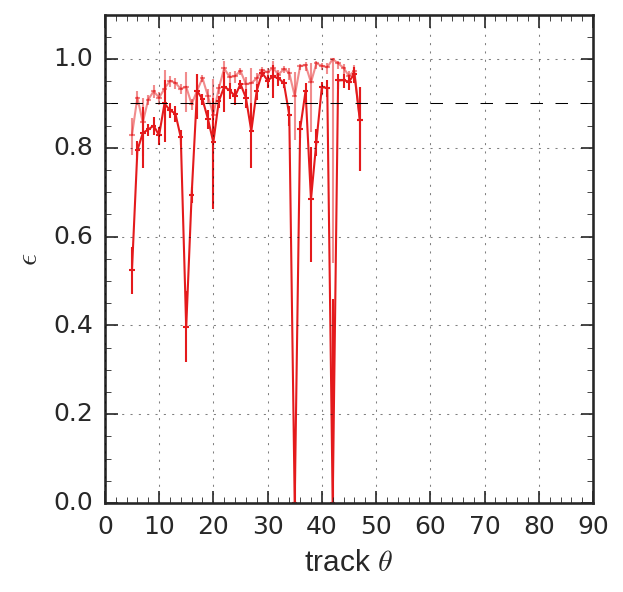

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:279: RuntimeWarning: invalid value encountered in true_divide


15 [           nan            nan            nan            nan
 8.16143315e-05 1.36873802e-04 8.48656294e-04 1.49154790e-03
 4.51859576e-03 7.42144323e-03 2.05350205e-02 6.66553883e-02
 1.76623377e-01 3.82802548e-01 5.93648208e-01 7.47582697e-01
 8.26299694e-01 8.34212509e-01 8.78953771e-01 8.92913386e-01
 8.95877009e-01 9.14320685e-01 8.96787423e-01 9.01673640e-01
 9.01360544e-01 9.01052632e-01]
25 [           nan            nan            nan            nan
 6.12107486e-05 3.42184506e-05 4.52616690e-04 4.97182632e-04
 1.27447573e-03 2.05273962e-03 4.44000444e-03 8.62798173e-03
 1.60566706e-02 3.18471338e-02 5.70032573e-02 1.17557252e-01
 1.87155963e-01 2.62245667e-01 3.86253041e-01 5.56692913e-01
 6.82739343e-01 8.12117503e-01 8.48257006e-01 8.80753138e-01
 8.81632653e-01 8.90526316e-01]


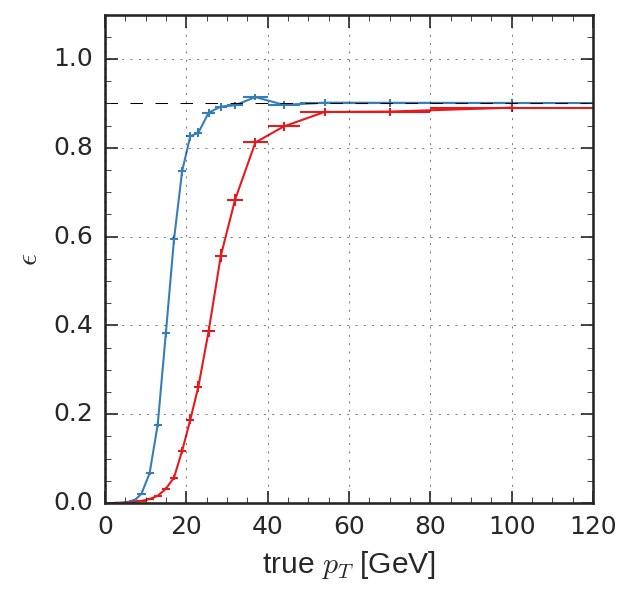

In [11]:
# Build track producer

from six.moves import range, zip, map, filter

pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

theta_to_eta_lut = [
   2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
   2.309, 2.284, 2.259, 2.236, 2.212, 2.19 , 2.167, 2.145, 2.124, 2.103,
   2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.95 , 1.932, 1.915,
   1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.8  , 1.785, 1.77 , 1.755,
   1.74 , 1.726, 1.711, 1.697, 1.683, 1.67 , 1.656, 1.642, 1.629, 1.616,
   1.603, 1.59 , 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
   1.482, 1.47 , 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
   1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
   1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
]

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - np.abs(ipt - best_ipt)

nvariables = nvariables

discr_pt_cut = discr_pt_cut

def get_theta_median_from_x(x):
  assert(x.shape[0] == nvariables)
  theta_median = x[-1] # last variable
  theta_median = (theta_median * 83) + 3
  return theta_median.astype(np.int32)

def get_zone_from_x(x):
  assert(x.shape[0] == nvariables)
  zone = x[-2] # second last variable
  zone = (zone * 5) + 0
  return zone.astype(np.int32)

def get_straightness_from_x(x):
  assert(x.shape[0] == nvariables)
  straightness = x[-3] # third last variable
  straightness = (straightness * 4) + 4
  return straightness.astype(np.int32)

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

# MK

#def get_mode_from_x_mask(x_mask):
#  assert(x_mask.shape[0] == nlayers)
#  assert(x_mask.dtype == np.bool)
#  valid = ~x_mask
#  mode = np.int32(0)
#  if np.any([valid[0], valid[1], valid[5], valid[9], valid[11]]):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
#    mode |= (1<<3)
#  if np.any([valid[2], valid[6], valid[10]]):  # ME2, RE2, GE2/1
#    mode |= (1<<2)
#  if np.any([valid[3], valid[7]]):  # ME3, RE3
#    mode |= (1<<1)
#  if np.any([valid[4], valid[8]]):  # ME4, RE4
#    mode |= (1<<0)
#
#  # Apply modified SingleMu requirement
#  mode_me0 = np.int32(0)
#  if valid[11]: # ME0
#    mode_me0 |= (1 << 2)
#  if valid[0]:  # ME1/1
#    mode_me0 |= (1 << 1)
#  if np.any([valid[2], valid[3], valid[4]]):  # ME2, ME3, ME4
#    mode_me0 |= (1 << 0)
#  if mode not in (11,13,14,15) and mode_me0 == 7:
#    mode = 11  # pretend as mode 11
#  return mode


def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any([valid[0], valid[1]]):   # ME1/1, ME1/2
    mode |= (1<<3)
  if np.any([valid[2]]):  # ME2
    mode |= (1<<2)
  if np.any([valid[3]]):  # ME3
    mode |= (1<<1)
  if np.any([valid[4]]):  # ME4
    mode |= (1<<0)

  return mode


class TrackProducer(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8005,  1.5194,  1.5708,  1.8247,  2.1989,  2.6489,  3.1625,  3.7251,
                  4.3240,  4.9595,  5.6337,  6.3424,  7.0590,  7.7485,  8.4050,  9.0398,
                  9.6598, 10.2800, 10.9236, 11.6060, 12.3216, 13.0521, 13.7887, 14.5427,
                 15.2964, 16.0232, 16.7303, 17.4535, 18.2066, 19.0044, 19.8400, 20.6934,
                 21.5215, 22.3143, 23.1066, 23.8221, 24.4586, 25.1335, 25.9083, 26.7333,
                 27.5310, 28.2623, 28.9778, 29.7226, 30.5507, 31.4670, 32.4541, 33.5263,
                 34.5659, 35.5155, 36.4457, 37.4019, 38.3762, 39.3604, 40.3595, 41.3763,
                 42.3333, 43.2434, 44.2686, 45.5962, 47.0878, 48.3783, 49.4891, 50.5445,
                 51.4431, 52.2846, 53.1180, 53.9492, 54.7793, 55.6090, 56.4384, 57.2676,
                 58.0967, 58.9257, 59.7547, 60.5836, 61.4125, 62.2413, 63.0702, 63.8990,
                 64.7278, 65.5566, 66.3854, 67.2142, 68.0430, 68.8718, 69.7006, 70.5293,
                 71.3581, 72.1869, 73.0157, 73.8444, 74.6732, 75.5020, 76.3307, 77.1595,
                 77.9882, 78.8170, 79.6458, 80.4745, 81.3033, 82.1321, 82.9608, 83.7896,
                 84.6183, 85.4471, 86.2759, 87.1046, 87.9334, 88.7621, 89.5909, 90.4197,
                 91.2484, 92.0772, 92.9059, 93.7347, 94.5635, 95.3922, 96.2210, 97.0497]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)


#  def get_trigger_pt(self, x, y_meas):
#    xml_pt = np.abs(1.0/y_meas)
#    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
#      return xml_pt
#
#    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
#      x = np.clip(x, bins[1], bins[2]-1e-5)
#      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
#      return binx.astype(np.int32)
#
#    def interpolate(x, x0, x1, y0, y1):
#      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
#      return y
#
#    binx = digitize(xml_pt)
#    if binx == self.s_nbins-1:  # check boundary
#      binx -= 1
#
#    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
#    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
#    pt = interpolate(xml_pt, x0, x1, y0, y1)
#    return pt    

    
  def get_trigger_pt(self, x, y_meas):
    xml_pt = np.abs(1.0/y_meas)
    return xml_pt


  def pass_trigger(self, strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=14.):
    ipt1 = strg
    ipt2 = find_pt_bin(y_meas)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)

    if mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > 14:
        trigger = (y_discr > 0.9136) # 98.0% coverage
      elif np.abs(1.0/y_meas) > discr_pt_cut:
        trigger = (y_discr > 0.7415) # 98.0% coverage
      else:
        trigger = (y_discr >= 0.)  # True
    else:
      trigger = (y_discr < 0.)  # False
    return trigger

  def run(self, slim_roads, variables, predictions, other_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(other_vars))

    tracks = []

    for myroad, myvars, mypreds, myother in zip(slim_roads, variables, predictions, other_vars):
      assert(len(myvars.shape) == 1)
      x = myvars
      x_mask = myother
      y_meas = np.asscalar(mypreds[...,0])
      y_discr = np.asscalar(mypreds[...,1])

      theta_median = get_theta_median_from_x(x)
      zone = get_zone_from_x(x)
      strg = get_straightness_from_x(x)
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)

      passed = self.pass_trigger(strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
      xml_pt = np.abs(1.0/y_meas)
      pt = self.get_trigger_pt(x, y_meas)

      if passed:
        trk_q = np.sign(y_meas)
        trk_emtf_phi = myroad.id[4]
        trk_emtf_theta = myroad.theta_median
        trk = Track(myroad.id, myroad.hits, mode, xml_pt, pt, trk_q, trk_emtf_phi, trk_emtf_theta, ndof, y_discr)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer()

# Efficiency
eff_data = []

for ievt, (x, x_mask, y_meas, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, y_test_meas[0], y_test_meas[1], y_test_true[0])):
  theta_median = get_theta_median_from_x(x)
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20.:
    print ievt, ndof, float(y_discr), float(pt_true), float(xml_pt), float(pt), passed
  
eff_data = np.asarray(eff_data)

# Efficiency
plt.figure()

pt = 20
color = my_palette[1]
gen_passed = eff_data[:, 1] > 30  # index 1 is pt_true
passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed

denom_hist, edges = np.histogram(eff_data[:, 5][gen_passed], bins=89, range=(0.5,89.5))  # index 5 is theta_median
num_hist, edges = np.histogram(eff_data[:, 5][passed], bins=89, range=(0.5,89.5))  # index 1 is pt_true
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
#print pt, ydata

plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] >= 0)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data[:, 5][passed], bins=89, range=(0.5,89.5))  # index 1 is pt_true
eff_hist = np.true_divide(num_hist, denom_hist)
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist

plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, alpha=0.5, marker=',', capsize=0, lw=1)
  
plt.plot([0,90], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,90)
plt.ylim(0,1.1)
plt.xlabel(r'track $\theta$')
plt.ylabel(r'$\epsilon$')
plt.show()

# Efficiency
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

# MK
#pt_list = (10., 20., 30., 40., 50., 60.)
pt_list = (15,25)
plt.figure()

denom_hist, edges = np.histogram(eff_data[:, 1], bins=eff_pt_bins)  # index 1 is pt_true

for pt, color in zip(pt_list, my_palette):
    passed = (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
    num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is pt_true
    eff_hist = np.true_divide(num_hist, denom_hist)
    
    xdata = (edges[1:] + edges[:-1])/2
    xerr = (edges[1:] - edges[:-1])/2
    yerr = find_efficiency_errors(denom_hist, num_hist)
    ydata = eff_hist
    
    ##########################################################
    ###########             Save           ###################    
    np.save(model_name_MK+'_eff_xdata'+str(pt)+'GeV',xdata)
    np.save(model_name_MK+'_eff_xerr'+str(pt)+'GeV',xerr)
    np.save(model_name_MK+'_eff_yerr'+str(pt)+'GeV',yerr)
    np.save(model_name_MK+'_eff_ydata'+str(pt)+'GeV',ydata)
    ##########################################################
    print pt, ydata
    
    plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

  50 2293  6.7106 30.5000 4 [24.119364] [0.9947187]
  56  372  4.8489 22.0000 4 [24.24638] [0.9769329]
  56 7108 12.3301 33.0000 3 [30.743532] [0.9297426]


[INFO    ] nevents: 258400/498400


<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>)
(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>)


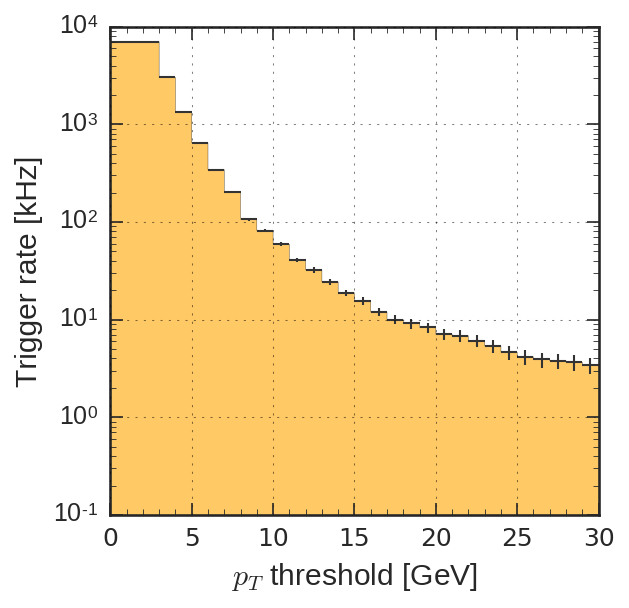

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 9.16566418856, 8.31020217389, 7.08811359853, 6.84369588643, 6.11044276506


[7.0174e+03, 7.0174e+03, 7.0174e+03, 3.0217e+03, 1.3349e+03, 6.4612e+02,
 3.4390e+02, 2.0311e+02, 1.0681e+02, 8.1513e+01, 5.9271e+01, 4.0940e+01,
 3.2263e+01, 2.4320e+01, 1.8820e+01, 1.5643e+01, 1.1976e+01, 1.0021e+01,
 9.1657e+00, 8.3102e+00, 7.0881e+00, 6.8437e+00, 6.1104e+00, 5.3772e+00,
 4.6439e+00, 4.1551e+00, 3.9107e+00, 3.7885e+00, 3.6663e+00, 3.4218e+00,
 3.4218e+00, 3.0552e+00, 3.0552e+00, 2.9330e+00, 2.6886e+00, 2.5664e+00,
 2.5664e+00, 2.5664e+00, 2.5664e+00, 2.5664e+00, 2.1998e+00, 2.0776e+00,
 2.0776e+00, 1.9553e+00, 1.9553e+00, 1.9553e+00, 1.9553e+00, 1.8331e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.4665e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.2221e+00, 1.2221e+00,
 1.2221e+00, 1.2221e+00, 1.2221e+00, 1.2221e+00, 1.2221e+00, 1.2221e+00,
 1.2221e+00, 1.2221e+00, 1.2221e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00,
 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.

In [12]:
# Rates
rates_jobid_offset = 101
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, y_meas, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test)):
  theta_median = get_theta_median_from_x(x)
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  trk_eta = theta_to_eta_lut[theta_median]
  
  if jobid < (rates_njobs-1):
    if passed and (1.24 <= trk_eta <= 2.4):
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and (1.24 <= trk_eta <= 2.4):
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), ndof, pt, y_discr
    if pt > 100.:  # wtf?
      with np_printoptions(precision=3, suppress=True):
        for lay in xrange(nlayers):
          tmp = np.arange(2) * nlayers + lay
          print "....", lay, x[tmp]

# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)
print(type(rates))
print(type(weights))
##########################################################
###########             Save           ###################
np.save(model_name_MK+'_rates',rates)
np.save(model_name_MK+'_weights',weights)
##########################################################
plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
print(type(xdata),type(xerr))
print(type(ydata),type(yerr))
##########################################################
###########             Save           ###################
np.save(model_name_MK+'_rates_xdata',xdata)
np.save(model_name_MK+'_rates_xerr',xerr)
np.save(model_name_MK+'_rates_ydata',ydata)
np.save(model_name_MK+'_rates_yerr',yerr)
##########################################################
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,30)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

In [13]:
# end